# Categorical Decision Trees

aka *Tree Ensembles*

- root node: the first decision node
- decision node: categorical input feature
- leaf node: prediction output

## Learning Process

How to decide which feature is the root node/a decision node?

- maximize purity (/minimize imputiry) between classified subsets

When do you stop splitting?

- when a node is 100% of one class
- when splitting a node will result in the tree exceeding the max *depth* (arbitrarily decided based on complexity)
- when improvements in purity score are bleow a threshold (or even increase the impurity)
- when a number of example in a node is below a threshold (to avoid overfitting and decrease depth)

## Measuring Purity

Using *entropy*, how do you decide to split at a node?

The equation for **impurity**:

- take log with base 2 just to make the max == 1
- another other base just vertically scales the function, makes it hard to interpolate
- take $(0)log(0)$ as $0$, not infiniti

$H(p_1) = -p_1log_2(p_1) = p_0log_2(p_0)$

Knowing:

$p_0 = 1 - p_1$,

$H(p_1) = -p_1log_2(p_1) = (1 - p_1)log_2(1 - p_1)$

> Note: *Genie criteria* is another form of this function, but this is easier to work with.

## Choosing a Split

- Calculate the impurity for left and right nodes
- get the weighted avg of the left and right impurities (like a decision matrix, based on [#exs / total] per left/right)
  - $w^{left}$: fraction of weight for left impurity
  - $w^{right}$: fraction of weight for right impurity
- convert this weighted avg into a "reduction in purity", as a measure of if you didn't split at all
  - $p_1 = 0.5$, $H(0.5) = 1$
  - converts this to the *information gain* represents a reduction in entropy (this can now be compared to a threshold)
  - (inverse of impurity = purity)
- select the feature that minimizes [$H(0.5)$ minus that avg impurity] (/maximizes purity)

![ ](info-gain.png)

## Recursive Splitting

Complete the information gain for all the following decision nodes, exactly the same as the root nodes (excelude the root node feature). This behaves recursively.

## Handling Non-Binary Features

### Categorical

aka *one-hot Encoding*

Assign a binary truth table for the amount of possible outputs. Replaces the non-binary categorical input entirely

> Note: this also applies for NNs 

### Continuous

Similar to logistic regression, apply a constant threshold to split the mapped categories into the two regions. Test 1 - total examples and select the one with the highest information gain.

![ ](cts-variable.png)

# Regression Decision Trees

Predicts a number by generalizing the categorical tree implementation.

Say we had to predict the weight of an animal instead of its category:

- select a feature(s) that contains the matching cts input (to output) and act as the "categorical encoding" for a numerical output
- use the variance of a cts input (feature) instead of the entropy
- similarly, use the reduction in variance as the information gain function

![ ](regression-split.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tree_utils import *

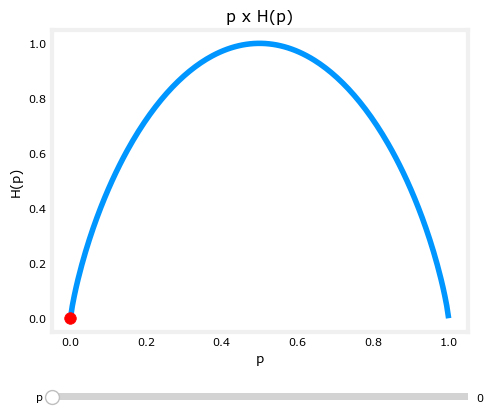

In [2]:
_ = plot_entropy()

In [3]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [4]:
#For instance, the first example
X_train[0]

array([1, 1, 1])

In [5]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


In [6]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [7]:
split_indices(X_train, 0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

In [8]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [9]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

In [10]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [11]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

In [12]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")
    

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


In [13]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


FileNotFoundError: [WinError 2] "dot" not found in path.

In [14]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=2, current_depth=0, tree = tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
- Depth 1, Left: Split on feature: 1
  -- Left leaf node with indices [0, 4, 5, 7]
  -- Right leaf node with indices [3]
- Depth 1, Right: Split on feature: 2
  -- Left leaf node with indices [1]
  -- Right leaf node with indices [2, 6, 8, 9]


FileNotFoundError: [WinError 2] "dot" not found in path.